In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def DCNN(nb_classes, Chans = 64, Samples = 256, dropoutRate = 0.5):
    
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 5), input_shape=(1, Chans, Samples),
                    kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1), kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5), kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5), kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5), kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def SCNN(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):

    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(40, (1, 13), input_shape=(1, Chans, Samples),
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                        kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [2]:
import numpy as np
import mne
from mne import io
from mne.datasets import sample
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baseline with high-pass filter
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=picks,
                    baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# scale data
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (144, 1, 60, 151)
144 train samples
72 test samples


In [3]:
model = SCNN(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
numParams = model.count_params()    

checkpointer = ModelCheckpoint(filepath='C:\\Users\\yousu\\Documents\\EEG Net\\checkpoint_scn.h5', 
                               verbose=2, save_best_only=True)

class_weights = {0:1, 1:1, 2:1, 3:1}

fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
# model.load_weights('/tmp/checkpoint_scn.h5')

# WEIGHTS_PATH = /path/to/preset-weights.h5 
# model.load_weights(WEIGHTS_PATH)

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 144 samples, validate on 72 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/300

Epoch 00001: val_loss improved from inf to 1.33775, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_scn.h5
 - 2s - loss: 1.7863 - acc: 0.2292 - val_loss: 1.3378 - val_acc: 0.3194
Epoch 2/300

Epoch 00002: val_loss improved from 1.33775 to 1.30943, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_scn.h5
 - 1s - loss: 1.3772 - acc: 0.3611 - val_loss: 1.3094 - val_acc: 0.3750
Epoch 3/300

Epoch 00003: val_loss did not improve from 1.30943
 - 1s - loss: 1.2565 - acc: 0.4097 - val_loss: 1.3143 - val_acc: 0.3750
Epoch 4/300

Epoch 00004: val_loss improved from 1.30943 to 1.28649, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_scn.h5
 - 1s - loss: 1.2487 - acc: 0.4306 -

Epoch 39/300

Epoch 00039: val_loss did not improve from 0.53444
 - 1s - loss: 0.0698 - acc: 1.0000 - val_loss: 0.5560 - val_acc: 0.7361
Epoch 40/300

Epoch 00040: val_loss did not improve from 0.53444
 - 1s - loss: 0.0712 - acc: 1.0000 - val_loss: 0.5563 - val_acc: 0.7361
Epoch 41/300

Epoch 00041: val_loss improved from 0.53444 to 0.49997, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_scn.h5
 - 1s - loss: 0.0695 - acc: 1.0000 - val_loss: 0.5000 - val_acc: 0.7778
Epoch 42/300

Epoch 00042: val_loss did not improve from 0.49997
 - 1s - loss: 0.0645 - acc: 1.0000 - val_loss: 0.5607 - val_acc: 0.7361
Epoch 43/300

Epoch 00043: val_loss did not improve from 0.49997
 - 1s - loss: 0.0682 - acc: 1.0000 - val_loss: 0.5436 - val_acc: 0.7500
Epoch 44/300

Epoch 00044: val_loss did not improve from 0.49997
 - 1s - loss: 0.0651 - acc: 1.0000 - val_loss: 0.5205 - val_acc: 0.7500
Epoch 45/300

Epoch 00045: val_loss did not improve from 0.49997
 - 1s - loss: 0.0598 - acc: 1.0000 - val_

Epoch 98/300

Epoch 00098: val_loss did not improve from 0.46985
 - 1s - loss: 0.0127 - acc: 1.0000 - val_loss: 0.5075 - val_acc: 0.7639
Epoch 99/300

Epoch 00099: val_loss improved from 0.46985 to 0.44804, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_scn.h5
 - 1s - loss: 0.0123 - acc: 1.0000 - val_loss: 0.4480 - val_acc: 0.7917
Epoch 100/300

Epoch 00100: val_loss did not improve from 0.44804
 - 1s - loss: 0.0133 - acc: 1.0000 - val_loss: 0.4633 - val_acc: 0.7639
Epoch 101/300

Epoch 00101: val_loss did not improve from 0.44804
 - 1s - loss: 0.0146 - acc: 1.0000 - val_loss: 0.4938 - val_acc: 0.7917
Epoch 102/300

Epoch 00102: val_loss did not improve from 0.44804
 - 1s - loss: 0.0121 - acc: 1.0000 - val_loss: 0.4801 - val_acc: 0.7917
Epoch 103/300

Epoch 00103: val_loss did not improve from 0.44804
 - 1s - loss: 0.0140 - acc: 1.0000 - val_loss: 0.5244 - val_acc: 0.7639
Epoch 104/300

Epoch 00104: val_loss did not improve from 0.44804
 - 1s - loss: 0.0104 - acc: 1.0000 -

Epoch 156/300

Epoch 00156: val_loss did not improve from 0.43629
 - 1s - loss: 0.0081 - acc: 1.0000 - val_loss: 0.5037 - val_acc: 0.7917
Epoch 157/300

Epoch 00157: val_loss did not improve from 0.43629
 - 1s - loss: 0.0080 - acc: 1.0000 - val_loss: 0.4861 - val_acc: 0.7917
Epoch 158/300

Epoch 00158: val_loss did not improve from 0.43629
 - 1s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.5467 - val_acc: 0.7778
Epoch 159/300

Epoch 00159: val_loss did not improve from 0.43629
 - 1s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4948 - val_acc: 0.8056
Epoch 160/300

Epoch 00160: val_loss did not improve from 0.43629
 - 1s - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4739 - val_acc: 0.8056
Epoch 161/300

Epoch 00161: val_loss did not improve from 0.43629
 - 1s - loss: 0.0067 - acc: 1.0000 - val_loss: 0.4664 - val_acc: 0.8056
Epoch 162/300

Epoch 00162: val_loss did not improve from 0.43629
 - 1s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.4694 - val_acc: 0.7917
Epoch 163/300

Epoch 00163: val_lo

Epoch 215/300

Epoch 00215: val_loss did not improve from 0.40590
 - 1s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.4795 - val_acc: 0.7917
Epoch 216/300

Epoch 00216: val_loss did not improve from 0.40590
 - 1s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.4666 - val_acc: 0.7917
Epoch 217/300

Epoch 00217: val_loss did not improve from 0.40590
 - 1s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.4863 - val_acc: 0.7917
Epoch 218/300

Epoch 00218: val_loss did not improve from 0.40590
 - 1s - loss: 0.0080 - acc: 1.0000 - val_loss: 0.4790 - val_acc: 0.8194
Epoch 219/300

Epoch 00219: val_loss did not improve from 0.40590
 - 1s - loss: 0.0062 - acc: 1.0000 - val_loss: 0.4972 - val_acc: 0.7778
Epoch 220/300

Epoch 00220: val_loss did not improve from 0.40590
 - 1s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.4879 - val_acc: 0.7917
Epoch 221/300

Epoch 00221: val_loss did not improve from 0.40590
 - 1s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4551 - val_acc: 0.7917
Epoch 222/300

Epoch 00222: val_lo

Epoch 275/300

Epoch 00275: val_loss did not improve from 0.40590
 - 1s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.4495 - val_acc: 0.8056
Epoch 276/300

Epoch 00276: val_loss did not improve from 0.40590
 - 1s - loss: 0.0059 - acc: 1.0000 - val_loss: 0.4798 - val_acc: 0.8333
Epoch 277/300

Epoch 00277: val_loss did not improve from 0.40590
 - 1s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4676 - val_acc: 0.8194
Epoch 278/300

Epoch 00278: val_loss did not improve from 0.40590
 - 1s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.4979 - val_acc: 0.8056
Epoch 279/300

Epoch 00279: val_loss did not improve from 0.40590
 - 1s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.4945 - val_acc: 0.8056
Epoch 280/300

Epoch 00280: val_loss did not improve from 0.40590
 - 1s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.4863 - val_acc: 0.8056
Epoch 281/300

Epoch 00281: val_loss did not improve from 0.40590
 - 1s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4765 - val_acc: 0.8194
Epoch 282/300

Epoch 00282: val_lo

In [4]:
model = DCNN(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
numParams    = model.count_params()    
checkpointer = ModelCheckpoint(filepath='C:\\Users\\yousu\\Documents\\EEG Net\\checkpoint_dcn.h5', 
                               verbose=2, save_best_only=True)

class_weights = {0:1, 1:1, 2:1, 3:1}

fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
#model.load_weights('/tmp/checkpoint_dcn.h5')

# WEIGHTS_PATH = /path/to/some-preset-weights.h5 
# model.load_weights(WEIGHTS_PATH)

prob = model.predict(X_test)
pred = prob.argmax(axis = -1)  
acc = np.mean(preds == Y_test.argmax(axis=-1))

print("Classification accuracy: %f " % (acc))

Train on 144 samples, validate on 72 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 1.34274, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 5s - loss: 1.6145 - acc: 0.2431 - val_loss: 1.3427 - val_acc: 0.3750
Epoch 2/300

Epoch 00002: val_loss improved from 1.34274 to 1.33441, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 1.5666 - acc: 0.2500 - val_loss: 1.3344 - val_acc: 0.2500
Epoch 3/300

Epoch 00003: val_loss improved from 1.33441 to 1.29979, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 1.3941 - acc: 0.3194 - val_loss: 1.2998 - val_acc: 0.3750
Epoch 4/300

Epoch 00004: val_loss improved from 1.29979 to 1.25078, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 1.3446 - acc: 0.3681 - val_loss: 1.2508 - val_acc: 0.3611
Epoch 5/300

Epoch 00005: val_loss improved from 1.25078 to 1.20617, saving model to C:\Users\yousu\Documents\EEG Net\checkpoin

Epoch 48/300

Epoch 00048: val_loss improved from 0.70265 to 0.70262, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 0.1902 - acc: 0.9375 - val_loss: 0.7026 - val_acc: 0.7222
Epoch 49/300

Epoch 00049: val_loss did not improve from 0.70262
 - 1s - loss: 0.1965 - acc: 0.9583 - val_loss: 0.7303 - val_acc: 0.6944
Epoch 50/300

Epoch 00050: val_loss improved from 0.70262 to 0.70213, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 0.2029 - acc: 0.9514 - val_loss: 0.7021 - val_acc: 0.7083
Epoch 51/300

Epoch 00051: val_loss did not improve from 0.70213
 - 1s - loss: 0.1879 - acc: 0.9514 - val_loss: 0.7416 - val_acc: 0.6944
Epoch 52/300

Epoch 00052: val_loss improved from 0.70213 to 0.69975, saving model to C:\Users\yousu\Documents\EEG Net\checkpoint_dcn.h5
 - 2s - loss: 0.2063 - acc: 0.9444 - val_loss: 0.6997 - val_acc: 0.6944
Epoch 53/300

Epoch 00053: val_loss did not improve from 0.69975
 - 2s - loss: 0.1885 - acc: 0.9514


Epoch 00103: val_loss did not improve from 0.59064
 - 2s - loss: 0.0443 - acc: 0.9931 - val_loss: 0.6198 - val_acc: 0.6944
Epoch 104/300

Epoch 00104: val_loss did not improve from 0.59064
 - 2s - loss: 0.0474 - acc: 1.0000 - val_loss: 0.6781 - val_acc: 0.7083
Epoch 105/300

Epoch 00105: val_loss did not improve from 0.59064
 - 1s - loss: 0.0490 - acc: 0.9931 - val_loss: 0.5949 - val_acc: 0.7361
Epoch 106/300

Epoch 00106: val_loss did not improve from 0.59064
 - 1s - loss: 0.0447 - acc: 1.0000 - val_loss: 0.7617 - val_acc: 0.7222
Epoch 107/300

Epoch 00107: val_loss did not improve from 0.59064
 - 2s - loss: 0.0511 - acc: 0.9931 - val_loss: 0.6317 - val_acc: 0.7083
Epoch 108/300

Epoch 00108: val_loss did not improve from 0.59064
 - 1s - loss: 0.0488 - acc: 1.0000 - val_loss: 0.6507 - val_acc: 0.7361
Epoch 109/300

Epoch 00109: val_loss did not improve from 0.59064
 - 2s - loss: 0.0476 - acc: 0.9931 - val_loss: 0.6975 - val_acc: 0.7222
Epoch 110/300

Epoch 00110: val_loss did not imp

Epoch 162/300

Epoch 00162: val_loss did not improve from 0.57967
 - 2s - loss: 0.0454 - acc: 0.9861 - val_loss: 0.8916 - val_acc: 0.7083
Epoch 163/300

Epoch 00163: val_loss did not improve from 0.57967
 - 2s - loss: 0.0532 - acc: 0.9861 - val_loss: 0.7501 - val_acc: 0.7361
Epoch 164/300

Epoch 00164: val_loss did not improve from 0.57967
 - 2s - loss: 0.0590 - acc: 0.9722 - val_loss: 0.6874 - val_acc: 0.7083
Epoch 165/300

Epoch 00165: val_loss did not improve from 0.57967
 - 2s - loss: 0.0328 - acc: 0.9931 - val_loss: 0.6701 - val_acc: 0.7778
Epoch 166/300

Epoch 00166: val_loss did not improve from 0.57967
 - 1s - loss: 0.0330 - acc: 1.0000 - val_loss: 0.8272 - val_acc: 0.6528
Epoch 167/300

Epoch 00167: val_loss did not improve from 0.57967
 - 1s - loss: 0.0146 - acc: 1.0000 - val_loss: 0.6950 - val_acc: 0.6806
Epoch 168/300

Epoch 00168: val_loss did not improve from 0.57967
 - 1s - loss: 0.0204 - acc: 1.0000 - val_loss: 0.6231 - val_acc: 0.6944
Epoch 169/300

Epoch 00169: val_lo

Epoch 221/300

Epoch 00221: val_loss did not improve from 0.57921
 - 1s - loss: 0.0114 - acc: 1.0000 - val_loss: 0.6581 - val_acc: 0.7361
Epoch 222/300

Epoch 00222: val_loss did not improve from 0.57921
 - 2s - loss: 0.0262 - acc: 0.9931 - val_loss: 0.6665 - val_acc: 0.7500
Epoch 223/300

Epoch 00223: val_loss did not improve from 0.57921
 - 1s - loss: 0.0131 - acc: 1.0000 - val_loss: 0.6613 - val_acc: 0.7222
Epoch 224/300

Epoch 00224: val_loss did not improve from 0.57921
 - 1s - loss: 0.0293 - acc: 0.9931 - val_loss: 0.7131 - val_acc: 0.7500
Epoch 225/300

Epoch 00225: val_loss did not improve from 0.57921
 - 1s - loss: 0.0183 - acc: 1.0000 - val_loss: 0.7431 - val_acc: 0.7083
Epoch 226/300

Epoch 00226: val_loss did not improve from 0.57921
 - 1s - loss: 0.0171 - acc: 1.0000 - val_loss: 0.7095 - val_acc: 0.6667
Epoch 227/300

Epoch 00227: val_loss did not improve from 0.57921
 - 1s - loss: 0.0081 - acc: 1.0000 - val_loss: 0.6761 - val_acc: 0.7361
Epoch 228/300

Epoch 00228: val_lo

Epoch 281/300

Epoch 00281: val_loss did not improve from 0.57921
 - 2s - loss: 0.0179 - acc: 0.9931 - val_loss: 0.6352 - val_acc: 0.7778
Epoch 282/300

Epoch 00282: val_loss did not improve from 0.57921
 - 1s - loss: 0.0228 - acc: 0.9931 - val_loss: 0.8741 - val_acc: 0.7083
Epoch 283/300

Epoch 00283: val_loss did not improve from 0.57921
 - 1s - loss: 0.0206 - acc: 0.9931 - val_loss: 0.7229 - val_acc: 0.7639
Epoch 284/300

Epoch 00284: val_loss did not improve from 0.57921
 - 1s - loss: 0.0238 - acc: 0.9931 - val_loss: 0.9032 - val_acc: 0.6806
Epoch 285/300

Epoch 00285: val_loss did not improve from 0.57921
 - 1s - loss: 0.0178 - acc: 1.0000 - val_loss: 0.7315 - val_acc: 0.7083
Epoch 286/300

Epoch 00286: val_loss did not improve from 0.57921
 - 2s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.8207 - val_acc: 0.6806
Epoch 287/300

Epoch 00287: val_loss did not improve from 0.57921
 - 2s - loss: 0.0223 - acc: 1.0000 - val_loss: 0.5904 - val_acc: 0.7500
Epoch 288/300

Epoch 00288: val_lo

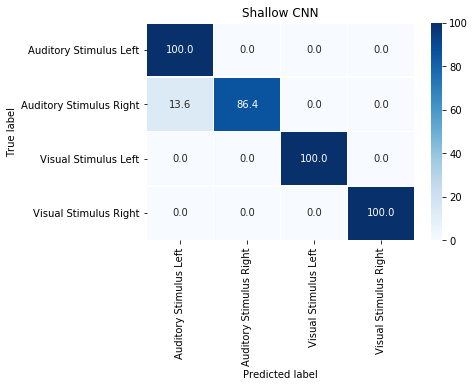

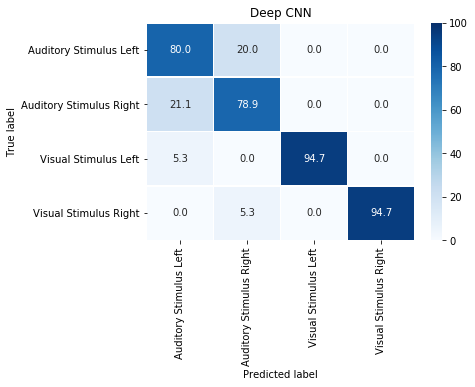

In [5]:
from pyriemann.utils.viz import plot_confusion_matrix

# confusion matrices for both classifiers
names = ['Auditory Stimulus Left', 'Auditory Stimulus Right', 
         'Visual Stimulus Left', 'Visual Stimulus Right']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'Shallow CNN')

plt.figure(1)
plot_confusion_matrix(pred, Y_test.argmax(axis = -1), names, title = 'Deep CNN')